In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pyvista as pv
import jax
import jax.numpy as jnp

In [2]:
import os
mike_optics_code_location = os.path.join(os.path.abspath(""),'mike_raytrace')

%bookmark current_directory
%cd {mike_optics_code_location}
from raytrace import const_to_vec3, vec_array_dot, vec_array_norm
from raytrace import Rays, Rectangle, IdealLens, SphericalMirror, ToroidalMirror, PlaneGrating
%cd current_directory

/home/mike/Documents/Utilities/mike_raytrace
(bookmark:current_directory) -> /home/mike/Documents/Proposals/2022_PICASSO
/home/mike/Documents/Proposals/2022_PICASSO


## Let's make an SHS system with a beamsplitter

In [3]:
interferometer_size = 25. # mm
heterodyne_wavelength = 121.56
groove_density = 6000.
litrrow_angle = np.arcsin(heterodyne_wavelength*1e-6*groove_density/2.)
np.rad2deg(litrrow_angle)

21.387890688181706

In [4]:
from scipy.spatial.transform import Rotation as Rot
grating_rotation = Rot.from_rotvec(-litrrow_angle*np.array([0,0,1.]))

n_spatial_fringes = 1.0
spatial_rotation_angle = n_spatial_fringes*heterodyne_wavelength*1e-6/(2*interferometer_size)
print(f'{spatial_rotation_angle=}')
print(f'{np.rad2deg(spatial_rotation_angle)*3600=}')
grating_spatial_rotation = Rot.from_rotvec(spatial_rotation_angle*np.array([1.,0,0.]))

spatial_rotation_angle=2.4311999999999997e-06
np.rad2deg(spatial_rotation_angle)*3600=0.5014709969479406


In [33]:
# point source at coordinates (0, -y -20, 0)
source_collimator_distance = 100. # mm
collimator_f_number = source_collimator_distance/interferometer_size
print(f'{collimator_f_number=}')


collimator_beam_splitter_distance = 50. # mm

collimator = IdealLens(center=[0., -collimator_beam_splitter_distance, 0],
                       normal=[0.,-1.,0],
                       width=interferometer_size,
                       f=source_collimator_distance)

beam_splitter = Rectangle(center=[0.,0.,0.],
                          normal=[1.,1.,0.],
                          vdir=[0,0,1],
                          width=[interferometer_size*np.sqrt(2.), interferometer_size],
                          reflectivity=0.5, 
                          transmission=0.5)

interferometer_arm_length = 50. # mm
grating1 = PlaneGrating(center=[-interferometer_arm_length, 0, 0],
                        normal=grating_rotation.apply([1.,0,0]),
                        vdir=[0,0,1.],
                        grating_vector=[0,-1.,0],
                        groove_density=groove_density,
                        width=interferometer_size/np.cos(litrrow_angle))
grating2 = PlaneGrating(center=[0, interferometer_arm_length, 0],
                        normal=grating_spatial_rotation.apply(grating_rotation.apply([0.,-1.,0])),
                        vdir=[0,0,1.],
                        grating_vector=[-1.,0.,0],
                        groove_density=groove_density,
                        width=interferometer_size/np.cos(litrrow_angle))
print(f'{grating1._width[0]=}')

# the function of this optic is to image the plane of the gratings onto the detector
grating_camera_distance = 100.
camera_detector_distance = 100.
magnification = camera_detector_distance/grating_camera_distance
print(f'camera magnification = {magnification}')
camera_f = 1/(1/grating_camera_distance+1/camera_detector_distance)
print(f'{camera_f=}')
print(f'camera f/# = {camera_f/interferometer_size}')

camera = IdealLens(center=[grating1._center[0]+grating_camera_distance,0,0],
                   normal=[-1.,0,0],
                   width=interferometer_size,
                   f=camera_f)

camera_focal_plane = Rectangle(center=[camera._center[0]+camera_f, 0, 0],
                               normal=[-1,0,0],
                               vdir=[0,0,1],
                               width=interferometer_size, 
                               transmission=1.)

detector = Rectangle(center=[camera._center[0]+camera_detector_distance, 0, 0],
                     normal=[-1,0,0],
                     vdir=[0,0,1],
                     width=magnification*interferometer_size)

collimator_f_number=4.0
grating1._width[0]=DeviceArray(26.8490134, dtype=float64)
camera magnification = 1.0
camera_f=50.0
camera f/# = 2.0


In [6]:
field_size_rad = np.arctan(0.475/collimator_f_number)
field_size_deg = np.rad2deg(field_size_rad)
field_size_deg

6.772159966113561

In [7]:
theoretical_resolving_power = 4*grating1._width[0]*np.sin(litrrow_angle)/(heterodyne_wavelength*1e-6)
print(f'{theoretical_resolving_power=}')
minimum_resolvable_wavelength_difference = heterodyne_wavelength/theoretical_resolving_power
print(f'{minimum_resolvable_wavelength_difference=}')

theoretical_resolving_power=DeviceArray(322188.160805, dtype=float64)
minimum_resolvable_wavelength_difference=DeviceArray(0.0003773, dtype=float64)


In [8]:
heterodyne_wavelength+minimum_resolvable_wavelength_difference

DeviceArray(121.5603773, dtype=float64)

In [9]:
n_angles=101
angle_array = np.linspace(-field_size_rad, field_size_rad, n_angles)

from scipy.spatial.transform import Rotation as R

ray_dirs = np.empty((n_angles, n_angles, 3))
for ia, alpha in enumerate(angle_array):
    for ib, beta in enumerate(angle_array):
        xrot = R.from_rotvec(alpha*np.array([1.,0,0]))
        zrot = R.from_rotvec(beta*np.array([0,0,1.]))
        
        tdir = zrot.apply(xrot.apply(np.array([0,1.,0])))
        
        ray_dirs[ia,ib,:] = tdir
        
ray_origins = np.zeros_like(ray_dirs) + [0,-collimator_beam_splitter_distance-source_collimator_distance,0]

heterodyne_rays = Rays(origins=ray_origins, directions=ray_dirs, wavelengths=heterodyne_wavelength)

test_wavelength = heterodyne_wavelength + 1.*minimum_resolvable_wavelength_difference
print(f'{test_wavelength=}')
testrays = Rays(origins=ray_origins, directions=ray_dirs, wavelengths=test_wavelength)

test_wavelength=DeviceArray(121.5603773, dtype=float64)


In [10]:
def system_trace(rays, optics_operations):
    output_rays = [rays.nancopy() for i in range(len(optics_operations)+1)]
    output_rays[0] = rays
    
    vecs = jnp.empty((len(optics_operations),)+rays.origins.shape)
    dist = jnp.empty((len(optics_operations),)+rays.origins.shape[:-1])
    
    for i_opt, opt_op in enumerate(optics_operations):
        if len(opt_op)==3:
            optic, operation, options = opt_op
        else:
            optic, operation = opt_op
            options = dict()

        output_rays[i_opt+1] = getattr(optic, operation)(output_rays[i_opt], **options)
        
        vecs = vecs.at[i_opt].set(output_rays[i_opt+1].origins - output_rays[i_opt].origins)
        dist = dist.at[i_opt].set(vec_array_norm(vecs[i_opt]))
    
    return output_rays, vecs, dist

In [11]:
path1 = [[collimator, 'refract'],
         [beam_splitter, 'reflect'],
         [grating1, 'diffract'],
         [beam_splitter, 'pass_through'],
         [camera, 'refract'],
         [camera_focal_plane, 'pass_through'],
         [detector, 'detect']]
path2 = [[collimator, 'refract'],
         [beam_splitter, 'pass_through'],
         [grating2, 'diffract'],
         [beam_splitter, 'reflect'],
         [camera, 'refract'],
         [camera_focal_plane, 'pass_through'],
         [detector, 'detect']]

output_rays_path1, vecs_path1, dist_path1 = system_trace(testrays, path1)
output_rays_path2, vecs_path2, dist_path2 = system_trace(testrays, path2)

In [12]:
def pv_ray_plot(plotter, rays, dist=10., rayskip=1):
    it_p0, it_d0 = np.reshape([rays.origins, 
                               rays.directions], (2, -1, 3))[:,::rayskip,:]
    
    for p0, d0 in it_array:
        line = pv.Line(pointa=p0, pointb=p0+dist*d0)
        plotter.add_mesh(line, color='white', line_width=2)
        
def pv_ray2ray_plot(plotter, rays0, rays1, dist=None, rayskip=1, raycolor='white'):
    if dist is None:
        dist = rays1.origins - rays0.origins
        dist = np.linalg.norm(dist, axis=-1)
        dist = np.nanmean(dist)

    flat_p0, flat_d0, flat_p1 = np.reshape(np.array([rays0.origins,
                                                     rays0.directions,
                                                     rays1.origins])[:,::rayskip, ::rayskip, :],
                                           (3,-1,3))
    
    for p0, d0, p1 in zip(flat_p0, flat_d0, flat_p1):
        if np.any(np.isnan(p1)):
            line = pv.Line(pointa=p0, pointb=p0+dist*d0)
            color = 'darkred'
        else:
            line = pv.Line(pointa=p0, pointb=p1)
            color = raycolor
        pl.add_mesh(line, color=color, line_width=2)

In [13]:
pl = pv.Plotter(lighting='three lights')
pl.set_background(pv.Color(np.repeat(0.9,3)), top=pv.Color(np.repeat(1.0,3)))
pl.add_mesh(collimator.get_pvobj(), color='silver')
pl.add_mesh(beam_splitter.get_pvobj(), color='green')
pl.add_mesh(grating1.get_pvobj(), color='blue')
pl.add_mesh(grating2.get_pvobj(), color='blue')
pl.add_mesh(camera.get_pvobj(), color='green')
pl.add_mesh(detector.get_pvobj(), color='gold')
pl.add_axes()

rayskip = int(np.floor(np.max(ray_dirs.shape[:2])/5.))
for i in range(len(output_rays_path1)-1):
    pv_ray2ray_plot(pl, 
                    output_rays_path1[i],
                    output_rays_path1[i+1],
                    rayskip=rayskip, dist=100,
                    raycolor='pink')
for i in range(len(output_rays_path2)-1):        
    pv_ray2ray_plot(pl, 
                    output_rays_path2[i],
                    output_rays_path2[i+1],
                    rayskip=rayskip, dist=100, 
                    raycolor='lightblue')

pl.camera.position = [5,5,500]
pl.camera.focal_point = camera._center
pl.camera.up = [-1,0,0]
pl.show(window_size=[1024, 512])

ViewInteractiveWidget(height=512, layout=Layout(height='auto', width='100%'), width=1024)

In [14]:
def path1_distance(rays):
    path1_rays, _, dist = system_trace(rays, path1)
    
    #return np.sum(dist, axis=0)
    return path1_rays[-1].dist_phase

def path2_distance(rays):
    path2_rays, _, dist = system_trace(rays, path2)
    #return np.sum(dist, axis=0)
    return path2_rays[-1].dist_phase

def get_detector_interference(rays):
    path1_rays, _, dist1 = system_trace(rays, path1)
    path2_rays, _, dist2 = system_trace(rays, path2)
    
    dist1 = path1_rays[-1].dist_phase
    dist2 = path2_rays[-1].dist_phase

    pdiff = dist1 - dist2
    
    p1_int = path1_rays[-1].intensities
    p2_int = path2_rays[-1].intensities
    
    combined = (p1_int
                + p2_int
                + 2*jnp.sqrt(p1_int*p2_int)* jnp.cos(2*jnp.pi/(1e-6*rays.wavelengths)*pdiff))
    
    return combined

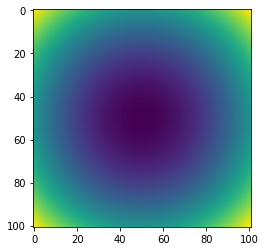

In [15]:
plt.imshow(path1_distance(testrays))

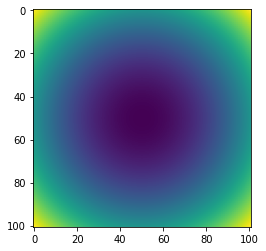

In [16]:
plt.imshow(path2_distance(testrays))

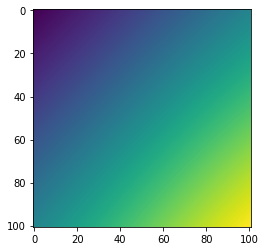

In [17]:
plt.imshow(path1_distance(testrays)-path2_distance(testrays))

CPU times: user 481 ms, sys: 0 ns, total: 481 ms
Wall time: 478 ms


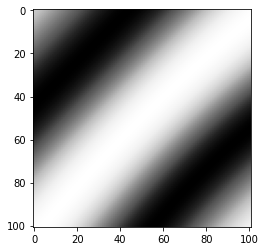

In [18]:
%%time
norm=mpl.colors.Normalize(vmin=0, vmax=2)
plt.imshow(get_detector_interference(testrays), norm=norm, cmap='Greys_r')

In [19]:
def get_inteferogram_for_wavelength_offset(q):
    test_wavelength = heterodyne_wavelength + q*minimum_resolvable_wavelength_difference
    testrays = Rays(origins=ray_origins, directions=ray_dirs, wavelengths=test_wavelength)
    return get_detector_interference(testrays)

jit_get_inteferogram_for_wavelength_offset = jax.jit(get_inteferogram_for_wavelength_offset)

In [20]:
def plot_inteferogram_for_wavelength_offset(q):
    norm=mpl.colors.Normalize(vmin=0, vmax=2)
    plt.imshow(jit_get_inteferogram_for_wavelength_offset(q), norm=norm, cmap='Greys_r')

CPU times: user 3.9 s, sys: 90.2 ms, total: 3.99 s
Wall time: 3.85 s


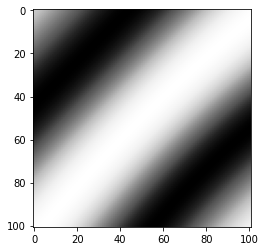

In [21]:
%%time
plot_inteferogram_for_wavelength_offset(1.0)

In [22]:
import ipywidgets as widgets
from ipywidgets import interactive

In [23]:
interactive(plot_inteferogram_for_wavelength_offset, q=widgets.FloatSlider(min=-15.0, max=15.0, value=1.0, step=0.5))

interactive(children=(FloatSlider(value=1.0, description='q', max=15.0, min=-15.0, step=0.5), Output()), _dom_…

In [24]:
rays1_coords = detector.transform_to_element(output_rays_path1[-1].origins)
(np.max(rays1_coords) - np.min(rays1_coords))/interferometer_size

DeviceArray(0.95667479, dtype=float64)

In [25]:
def fringe_formula(wavelength, x, y):
    return 1 + np.cos(2 * np.pi
                      * ( 4*( 1/wavelength - 1/heterodyne_wavelength ) * x * 1e6 * np.tan(litrrow_angle) 
                         - 2 * spatial_rotation_angle * y * 1e6 / heterodyne_wavelength ))

def fringe_brightness(wavelength, n_pix=101, scale=1.0):
    halfwidth = interferometer_size/2.
    pixels = np.linspace(-halfwidth, halfwidth, n_pix)
    pixels *= scale
    x, y = np.meshgrid(pixels, pixels)
    return fringe_formula(wavelength, x, y)

In [26]:
def get_fringe_for_wavelength_offset(q, scale=1.0):
    return fringe_brightness(heterodyne_wavelength + q*minimum_resolvable_wavelength_difference, scale=scale)

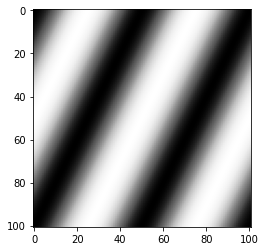

In [27]:
norm=mpl.colors.Normalize(vmin=0, vmax=2)
plt.imshow(get_fringe_for_wavelength_offset(2.0), 
           norm=norm, cmap='Greys_r')

Looks pretty good --- the variations in the raytraced image are a result of the hyperbolic fringes produced by the two point sources, which is not accounted for in the simple formulation for fringe frequency used above.

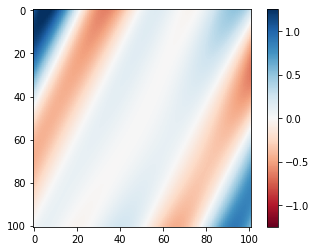

In [34]:
test_offset = 2.0
test_norm_value = 1.25
test_norm = mpl.colors.Normalize(vmin=-test_norm_value, vmax=test_norm_value)
plt.imshow(get_inteferogram_for_wavelength_offset(test_offset)
           -get_fringe_for_wavelength_offset(test_offset, scale=1.0),
           norm=test_norm, 
           cmap='RdBu')
plt.colorbar()